<div style="text-align: center">
	<h1> TOP Verkleg Æfing </h1>
	<h3> Snúningspendúll (Torsional Pendulum) </h3>
	<i> Authors </i>
</div>

In [100]:
using DataFrames, Statistics, CSV
using Measurements, Unitful
using Plots, PlotThemes
using EasyFit, Peaks, Symbolics, Latexify
plotlyjs();

## Gögn

### Gögn 1, mæling á kraft og θ

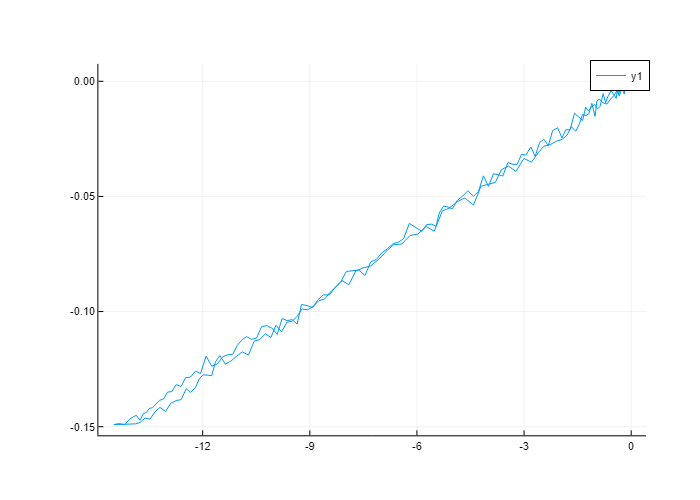

In [82]:
data = CSV.read("data.csv", DataFrame)

data = data[data[!,1] .> -0.15,:]

plot(data[!,2],data[!,1])

### Gögn 2, Mæling á θ yfir tíma með málmskífu
Með hápunktum og y-ás hliðraður

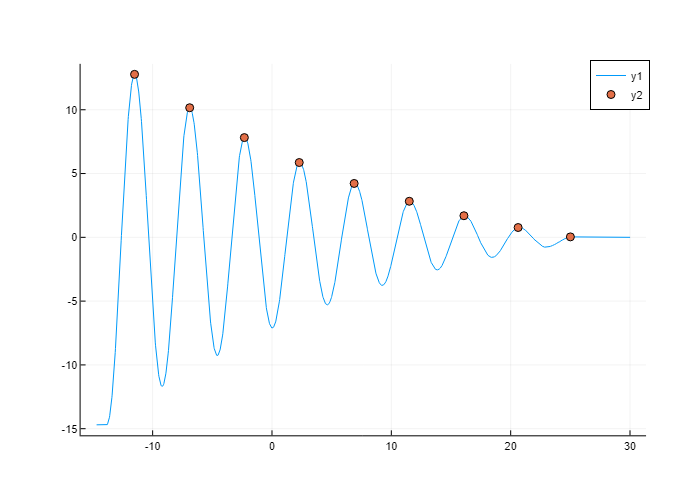

In [83]:
data2 = CSV.read("data2.csv", DataFrame)

data2 = data2 .- data2[end,2]

plot(data2[!,1], data2[!,2])

peaks = findmaxima(data2[!,2])
peaks = peaks[1][peaks[2] .> -10]

scatter!(data2[peaks,1],data2[peaks,2])

#### Gögn 2 nema abs

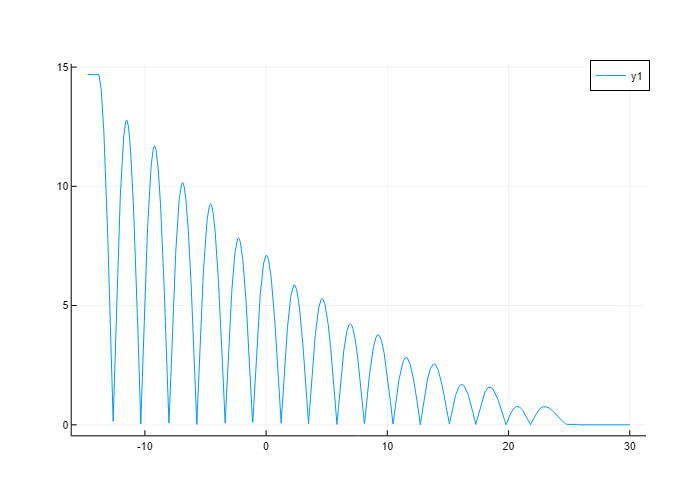

In [84]:
plot(data2[!,1], abs.(data2[!,2]))

#### Gögn 2 hápunktar nema $\log_e$ skali á y-ás

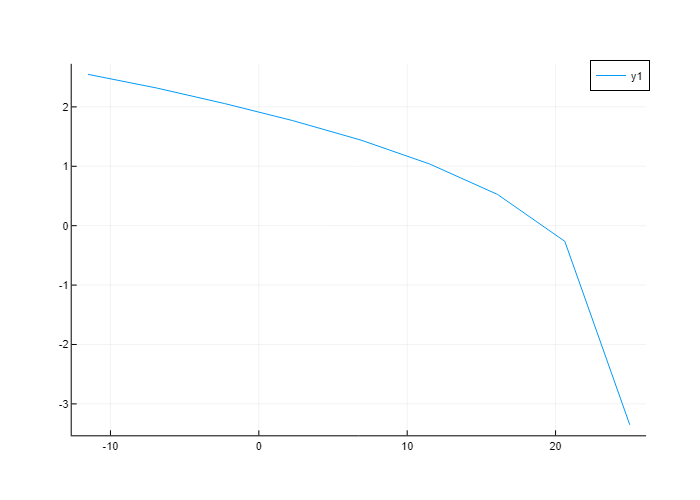

In [99]:
plot(data2[peaks,1], log.(data2[peaks,2]))

### Gögn 3, Mæling á θ yfir tíma nema með segul á topp súlunar

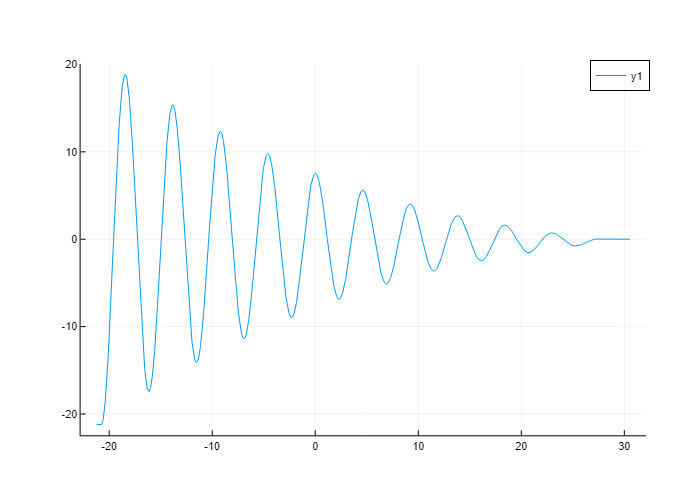

In [86]:
data3 = CSV.read("data3.csv", DataFrame)
data3 = data3 .- data3[end,2]

plot(data3[!,1], data3[!,2])

### Gögn 4, Mæling á θ yfir tíma nema með segul á hlið topp súlunar

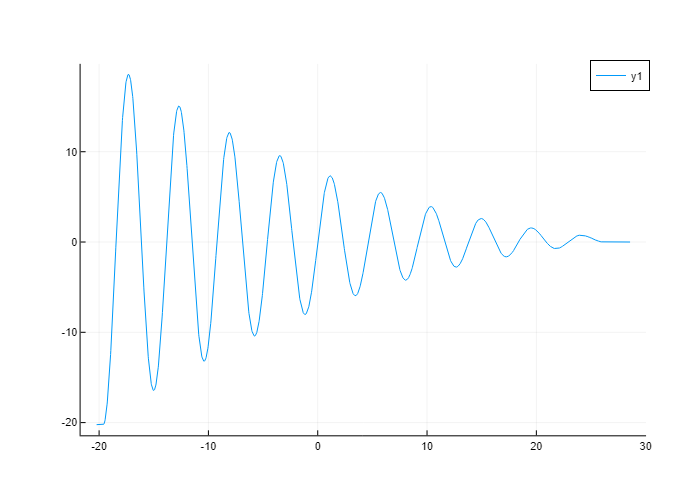

In [87]:
data4 = CSV.read("data4.csv", DataFrame)
data4 = data4 .- data4[end,2]

plot(data4[!,1], data4[!,2])

## Útreykningar

### Góða gamla fallið

In [88]:
"""
Fall til að fynna jöfnu óvissu fyrir gefna jöfnu
"""
function findErrorFromSym(symExpr; errorPrefix = "Err")
	vars = Symbolics.get_variables(symExpr)
	varErrs = []

	for i in vars
		push!(varErrs, Symbolics.variable(string(errorPrefix,i)))
	end

	Dvars = [expand_derivatives(Differential(i)(symExpr)) for i in vars]

	symErr = sqrt(sum((Dvars[i]*varErrs[i])^2 for i in eachindex(vars)))
	
	return symErr
end

findErrorFromSym (generic function with 1 method)

### Mælingar

In [89]:
kₛ = fitlinear(data[!,2],data[!,1]).a*1u"N*m"

0.010578748137015617 m N

In [90]:
rskvfull = (5.16±0.01)u"cm"
rskvinn = (0.27±0.01)u"cm"
rₛ = rskvfull-rskvinn

4.89 ± 0.014 cm

In [91]:
r = (9.5)
Δr = 0.1
m = (122)
Δm = 1
k = fitlinear(data2[peaks,1],log.(data2[peaks,2]))


 ------------------- Linear Fit ------------- 

 Equation: y = ax + b 

 With: a = -0.12751728726254244
       b = 1.7714598834466944

 Pearson correlation coefficient, R = 0.874955589289366
 Average square residue = 0.695718033797647

 Predicted Y: ypred = [3.2399489635621332, 2.650819096409187...
 residues = [0.6924588274723651, 0.33265597345182263...

 -------------------------------------------- 


### Jöfnur og útreikningar

#### Óvissa k

In [92]:
latexify(:(Δk=sqrt(n/(n*sum(x.^2)-sum(x.^2)))),env = :eq)

L"\begin{equation}
{\Delta}k = \sqrt{\frac{n}{n \cdot \sum x^{2} - \sum x^{2}}}
\end{equation}
"

In [93]:
x = data2[peaks,1]
n = length(x)
Δk = sqrt(n/(n*sum(x.^2)-sum(x.^2)))

0.025879541985573656

#### Jöfnur og útreikningar fyrir b og Δb

In [95]:
@variables κ R M Δκ ΔR ΔM
b = -1/2 *M*R^2*κ

-0.5M*κ*(R^2)

In [96]:
Δb = findErrorFromSym(b,errorPrefix = "Δ")

sqrt(0.25(M^2)*(R^4)*(Δκ^2) + 0.25(R^4)*(ΔM^2)*(κ^2) + (M^2)*(R^2)*(ΔR^2)*(κ^2))

In [97]:
bfun = eval(build_function(b, M,κ,R))
Δbfun = eval(build_function(Δb, M,R,Δκ,ΔM,κ,ΔR))
b = substitute(b, Dict([κ => k.a, R => r, M => m]))
b = bfun(m, k.a, r);
@show b;

b = 702.0145457021117


In [98]:
Δb = Δbfun(m,r, Δk, Δm,k.a, Δr);
b = substitute(Δb, Dict([κ => k.a, R => r, M => m, ΔM => Δm, Δκ => Δk, ΔR => Δr]))

@show Δb;

Δb = 143.35338291864204
